In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests

from env import github_token, github_username

import acquire_zach as az
import wrangle as w

import numpy as np
import pandas as pd

# acquire
from requests import get
from bs4 import BeautifulSoup
from time import sleep
import os

# prepare
import unicodedata
import re
import json
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# explore
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# model
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Acquire

In [2]:
df = pd.read_csv('google_readmes.csv').drop(columns="Unnamed: 0")

In [3]:
df.head(2)

,repo,language,readme_contents
0,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...
1,google/megalista,Python,# Megalista\n\nSample integration code for onb...


# Explore

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943 entries, 0 to 1942
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1943 non-null   object
 1   language         1943 non-null   object
 2   readme_contents  1943 non-null   object
dtypes: object(3)
memory usage: 45.7+ KB


In [7]:
df.isnull().value_counts()

repo   language  readme_contents
False  False     False              1943
dtype: int64

In [8]:
df.language.value_counts()

C++                 402
Python              268
Java                268
JavaScript          201
TypeScript          134
Kotlin              134
Go                  134
HTML                 67
Rust                 67
Shell                67
C                    67
Jupyter Notebook     67
Starlark             67
Name: language, dtype: int64

<AxesSubplot:>

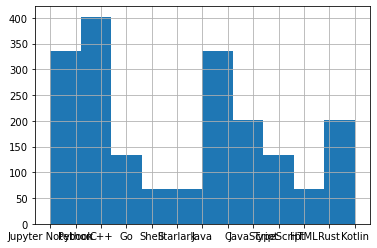

In [16]:
df.language.hist()

[Text(0.5, 1.0, 'Distribution of Google Coding Languages in Github Repos'),
 Text(0.5, 0, 'Number of Repos')]

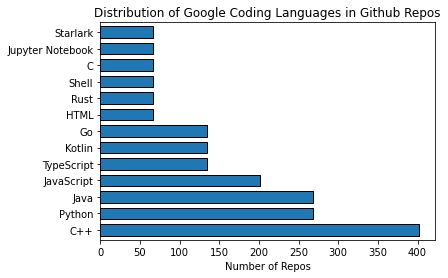

In [26]:
ax = df.language.value_counts().plot.barh(width=.7, ec='black')
plt.xticks(rotation=0)
ax.set(title='Distribution of Google Coding Languages in Github Repos', xlabel='Number of Repos')

In [89]:
(df.language == "HTML").value_counts()

False    1876
True       67
Name: language, dtype: int64

In [40]:
length = []
for i in range(0,1942):
    text_len = len(df.readme_contents[i])
    length.append(text_len)

length

[16042,
 9021,
 2447,
 9098,
 17816,
 2186,
 3372,
 1945,
 1571,
 3918,
 619,
 8712,
 3760,
 2422,
 274,
 5185,
 4131,
 3701,
 11034,
 299,
 6199,
 5276,
 5603,
 1032,
 48063,
 883,
 9772,
 3460,
 3245,
 16042,
 9021,
 2447,
 9098,
 17816,
 2186,
 3372,
 1945,
 1571,
 3918,
 619,
 8712,
 3760,
 2422,
 274,
 5185,
 4131,
 3701,
 11034,
 299,
 6199,
 5276,
 5603,
 1032,
 48063,
 883,
 9772,
 3460,
 3245,
 16042,
 9021,
 2447,
 9098,
 17816,
 2186,
 3372,
 1945,
 1571,
 3918,
 619,
 8712,
 3760,
 2422,
 274,
 5185,
 4131,
 3701,
 11034,
 299,
 6199,
 5276,
 5603,
 1032,
 48063,
 883,
 9772,
 3460,
 3245,
 16042,
 9021,
 2447,
 9098,
 17816,
 2186,
 3372,
 1945,
 1571,
 3918,
 619,
 8712,
 3760,
 2422,
 274,
 5185,
 4131,
 3701,
 11034,
 299,
 6199,
 5276,
 5603,
 1032,
 48063,
 883,
 9772,
 3460,
 3245,
 16042,
 9021,
 2447,
 9098,
 17816,
 2186,
 3372,
 1945,
 1571,
 3918,
 619,
 8712,
 3760,
 2422,
 274,
 5185,
 4131,
 3701,
 11034,
 299,
 6199,
 5276,
 5603,
 1032,
 48063,
 883,
 9772,

In [45]:
def get_readme_length():
    """
    This function reads the length of each readme and
    appends it to a list.
    """
    
    length = []
    for i in range(0,1943):
        text_len = len(df.readme_contents[i])
        length.append(text_len)
    
    return length

In [34]:
len(df.readme_contents[0]

16042

In [46]:
df['readme_length'] = get_readme_length()

In [47]:
df.head(2)

,repo,language,readme_contents,readme_length
0,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042
1,google/megalista,Python,# Megalista\n\nSample integration code for onb...,9021


<AxesSubplot:>

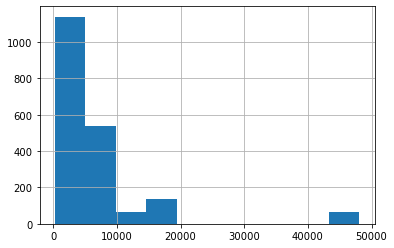

In [50]:
df.readme_length.hist()

In [55]:
df.readme_length.describe()

count     1943.000000
mean      6589.172414
std       8959.948717
min        274.000000
25%       2186.000000
50%       3760.000000
75%       8712.000000
max      48063.000000
Name: readme_length, dtype: float64

<AxesSubplot:xlabel='readme_length'>

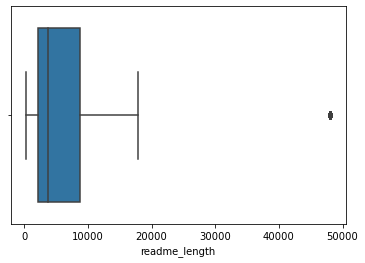

In [57]:
sns.boxplot(data=df, x='readme_length')

In [90]:
(df.readme_length > 20_000).sum()

67

In [91]:
df[df.readme_length > 20_000]

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
24,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
53,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
82,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
111,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
140,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
...,...,...,...,...,...,...
1822,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
1851,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
1880,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676
1909,google/benchmark,C++,# Benchmark\n\n[![build-and-test](https://gith...,48063,"[benchmark, buildandtesthttpsgithubcomgooglebe...",3676


In [99]:
df.repo.duplicated().value_counts()

True     1914
False      29
Name: repo, dtype: int64

In [101]:
df[df.repo.duplicated()].sort_values(by=['repo'])

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
29,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
754,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
203,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
783,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
1479,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
...,...,...,...,...,...,...
567,google/zx,JavaScript,# 🐚 zx\n\n```js\n#!/usr/bin/env zx\n\nawait $`...,4131,"[zx, j, usrbinenv, zx, await, cat, packagejson...",382
1002,google/zx,JavaScript,# 🐚 zx\n\n```js\n#!/usr/bin/env zx\n\nawait $`...,4131,"[zx, j, usrbinenv, zx, await, cat, packagejson...",382
596,google/zx,JavaScript,# 🐚 zx\n\n```js\n#!/usr/bin/env zx\n\nawait $`...,4131,"[zx, j, usrbinenv, zx, await, cat, packagejson...",382
509,google/zx,JavaScript,# 🐚 zx\n\n```js\n#!/usr/bin/env zx\n\nawait $`...,4131,"[zx, j, usrbinenv, zx, await, cat, packagejson...",382


In [100]:
df[df.duplicated(['repo'])==True].head(20)

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
29,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
30,google/megalista,Python,# Megalista\n\nSample integration code for onb...,9021,"[megalista, sample, integration, code, onboard...",696
31,google/timesketch,Python,# Timesketch\n[![Open In Colab](https://colab....,2447,"[timesketch, open, colabhttpscolabresearchgoog...",100
32,google/iree,C++,# IREE: Intermediate Representation Execution ...,9098,"[iree, intermediate, representation, execution...",555
33,google/highway,C++,# Efficient and performance-portable SIMD\n\nH...,17816,"[efficient, performanceportable, simd, highway...",1536
34,google/agi,Go,# Android GPU Inspector\n\n<!-- TODO(b/1551593...,2186,"[android, gpu, inspector, todob155159330, reac...",127
35,google/oss-fuzz,Shell,# OSS-Fuzz: Continuous Fuzzing for Open Source...,3372,"[ossfuzz, continuous, fuzzing, open, source, s...",230
36,google/llvm-bazel,Starlark,# LLVM Bazel BUILD files\n\nDISCLAIMER: This i...,1945,"[llvm, bazel, build, file, disclaimer, officia...",123
37,google/truth,Java,[![Main Site][gh-pages-shield]][gh-pages-link]...,1571,"[main, siteghpagesshieldghpageslink, build, st...",71
38,google/clspv,C,# clspv\n\n**Clspv** is a prototype compiler f...,3918,"[clspv, clspv, prototype, compiler, subset, op...",333


In [ ]:
# transform into a series

string = " ".join(news_df.readme_contents)

string = " ".join(clean(string))

In [8]:
words = pd.Series(string.split())

# From the Series we can extract the value_counts, which is our raw count
# for term frequency. Once we have the raw counts, we can calculate the
# other measures.
(pd.DataFrame({'raw_count': words.value_counts()})
 .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
 .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

,raw_count,frequency,augmented_frequency
benchmark,9045,0.009729,1.000000
build,6901,0.007423,0.762963
n,6164,0.006630,0.681481
use,6164,0.006630,0.681481
task,5829,0.006270,0.644444
...,...,...,...
roadmapdocsdevelopersdesign_roadmapmd,67,0.000072,0.007407
multiplier,67,0.000072,0.007407
longterm,67,0.000072,0.007407
embeds,67,0.000072,0.007407


In [61]:
df['clean_content'] = df.readme_contents.apply(w.clean)

In [59]:
df.head(2)

,repo,language,readme_contents,readme_length
0,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042
1,google/megalista,Python,# Megalista\n\nSample integration code for onb...,9021


In [62]:
df.head(2)

,repo,language,readme_contents,readme_length,clean_content
0,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben..."
1,google/megalista,Python,# Megalista\n\nSample integration code for onb...,9021,"[megalista, sample, integration, code, onboard..."


In [70]:
def get_length(column):
    """
    This function reads the length of each readme and
    appends it to a list.
    """
    
    length = []
    for i in range(0,1943):
        text_len = len(df[column][i])
        length.append(text_len)
    
    return length

In [71]:
df['cleaned_length'] = get_length("clean_content")

In [72]:
df.head(2)

,repo,language,readme_contents,readme_length,clean_content,cleaned_length
0,google/BIG-bench,Jupyter Notebook,# BIG-bench :chair:\n\nThe Beyond the Imitatio...,16042,"[bigbench, chair, beyond, imitation, game, ben...",1111
1,google/megalista,Python,# Megalista\n\nSample integration code for onb...,9021,"[megalista, sample, integration, code, onboard...",696


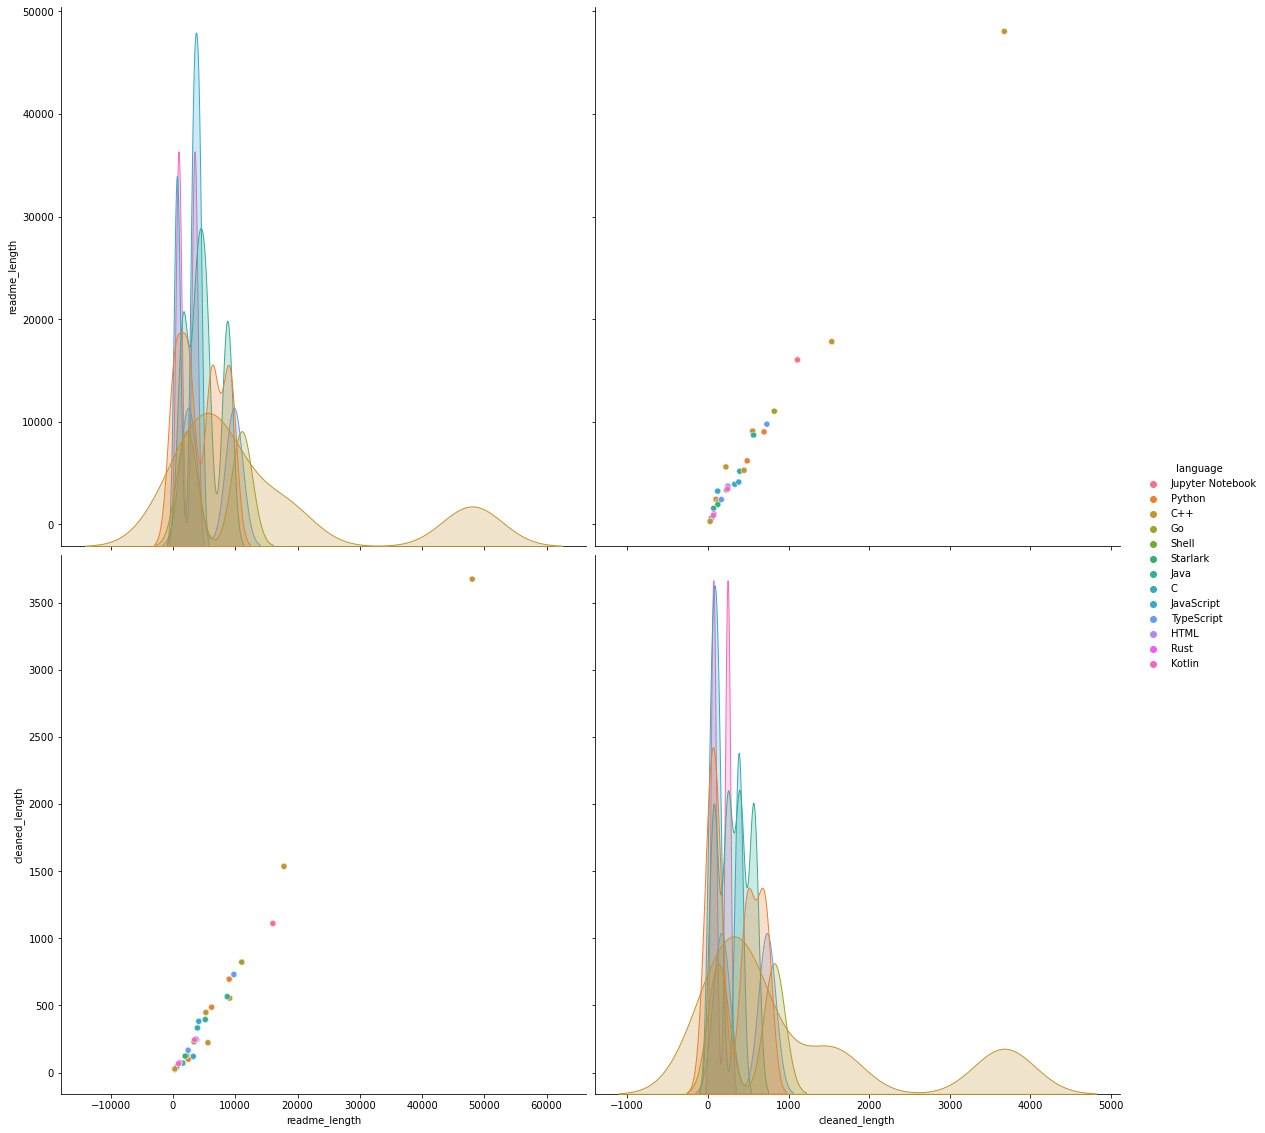

In [82]:
#fig, ax = plt.subplots(figsize=(20,20))
sns.pairplot(df, hue='language', height=8, aspect=1)